# Calculating NDVI

In [1]:
import ee, datetime
import pandas as pd
from pylab import *
from matplotlib.pylab import rcParams
from netCDF4 import Dataset
import numpy as np
%matplotlib inline

In [2]:
ee.Initialize()

In [3]:
SatImage = ee.ImageCollection("LANDSAT/LC08/C01/T1_TOA")

### Region of interest is a village in Estonia

In [4]:
roi = {'type':'Point', 'coordinates':[ 58.035420, 26.344237 ]}

### Time period 2016-01-01 to 2016-12-31

In [5]:
SatImageTime = SatImage.filterDate('2016-01-01', '2016-12-31') #YYYY-MM-DD

In [6]:
info = SatImageTime.getRegion(roi, 500).getInfo()

In [7]:
header = info[0]
data = array(info[1:])

iTime = header.index('time')

time = [datetime.date.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

BandsUsed = ['B4','B5']

iBands = [header.index(b) for b in BandsUsed]
yData = data[0:,iBands].astype(np.float)

red = yData[:,0]
nir = yData[:,1]
ndvi = (nir - red) / (nir + red) #Calculating NDVI

In [8]:
NDVIdf = pd.DataFrame(data=ndvi, index=list(range(len(ndvi))), columns=['NDVI']) #Storing values in a Dataframe

#Creating a timeseries
NDVIdf['Date'] = pd.Series(time, index=NDVIdf.index)

NDVIdf['Date'] = pd.Series((NDVIdf.Date-NDVIdf.Date.min()).astype('timedelta64[D]').astype(int)+1, index=NDVIdf.index)


In [9]:
NDVIdf = NDVIdf.sort_values('Date')
NDVIdf = NDVIdf.reset_index() 
NDVIdf = NDVIdf.drop('index', axis = 1)

## Plotting NDVI

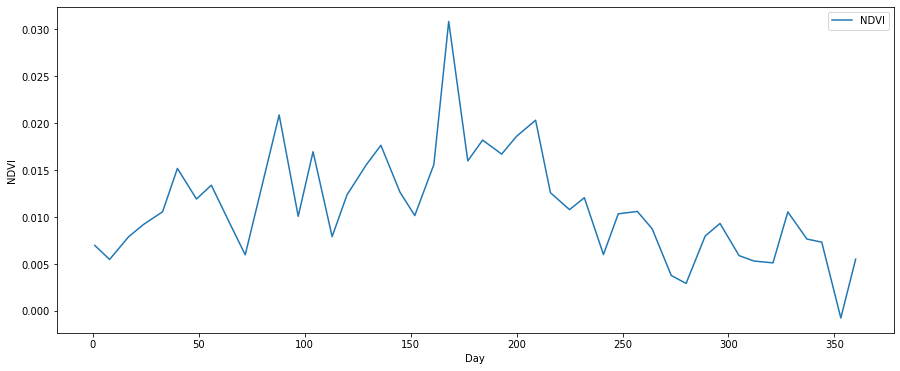

In [10]:
rcParams['figure.figsize'] = 15, 6
ax = NDVIdf.plot(y='NDVI', x='Date')
ax.set_xlabel('Day')
ax.set_ylabel('NDVI')
plt.show()

# Extracting LAI from output file (US NR-1), Jan-Dec, 2005

In [11]:
output_file = '2005.nc'
file = Dataset(output_file, mode='r')

In [12]:
LAI = file.variables['LAI'][:]
TIME = file.variables['time'][:]

In [13]:
l =  np.ma.filled(LAI)
t =  np.ma.filled(TIME)

In [14]:
lai = l.ravel()
ti = t.ravel()

In [15]:
LAIdf = pd.DataFrame({'LAI':lai, 'Time':ti}) #Putting the values in a DataFrame


## Plotting LAI

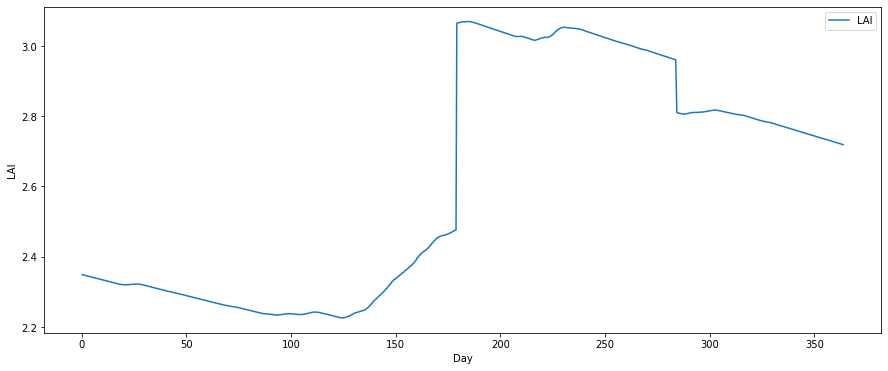

In [16]:
rcParams['figure.figsize'] = 15, 6
ax = LAIdf.plot(y='LAI',x='Time')
ax.set_xlabel('Day')
ax.set_ylabel('LAI')
plt.show()

## Comparing NDVI and LAI

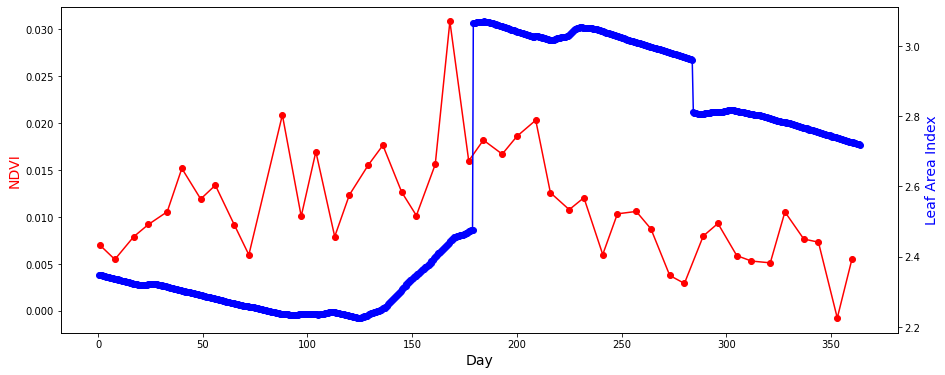

In [17]:
fig,ax = plt.subplots()

ax.plot(NDVIdf.Date, NDVIdf.NDVI, color="red", marker="o")

ax.set_xlabel("Day",fontsize=14)

ax.set_ylabel("NDVI",color="red",fontsize=14)

ax2=ax.twinx()

ax2.plot(LAIdf.Time, LAIdf.LAI,color="blue",marker="o")

ax2.set_ylabel("Leaf Area Index",color="blue",fontsize=14)

plt.show()
